<a href="https://colab.research.google.com/github/KoalaMuch/2018-Data-Science-Bowl/blob/main/U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
!echo '{"username":"theerutseekeaw","key":"dd5f331b0c58512a952651a387ed2200"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!kaggle competitions download -c data-science-bowl-2018

data-science-bowl-2018.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip -q data-science-bowl-2018.zip

replace stage1_sample_submission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [141]:
!unzip -q -o stage1_train.zip -d /content/stage1_train
!unzip -q -o stage1_test.zip -d /content/all_test
!unzip -q -o stage2_test_final.zip -d /content/all_test
!unzip -q -o stage1_test.zip -d /content/stage1_test
!unzip -q -o stage2_test_final.zip -d /content/stage2_test

In [142]:
import os

TRAIN_PATH = '/content/stage1_train/'
TEST1_PATH = '/content/stage1_test/'
TEST2_PATH = '/content/stage2_test/'
TEST_PATH = '/content/all_test/'
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
test1_ids = next(os.walk(TEST1_PATH))[1]
test2_ids = next(os.walk(TEST2_PATH))[1]

3084 3084 3019 670


In [38]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

seed = 42
np.random.seed(42)

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNEL = 3

X_train = np.zeros((len(train_ids), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL), dtype=np.uint8)
y_train = np.zeros((len(train_ids), IMG_WIDTH, IMG_HEIGHT, 1), dtype=np.bool)

for i,id in enumerate(train_ids):
  fname = TRAIN_PATH+id+'/images/'+id+'.png'
  X_train[i] = cv2.resize(cv2.imread(fname), (128, 128))
  mask_ids = next(os.walk(TRAIN_PATH+id+'/masks'))[2]
  mask = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype=np.bool)
  for mask_id in mask_ids:
    fname = TRAIN_PATH+id+'/masks/'+mask_id
    mask_ = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2GRAY)
    (_, mask_) = cv2.threshold(mask_, 127, 255, cv2.THRESH_BINARY)
    mask_ = np.expand_dims(cv2.resize(mask_, (128, 128)), axis=-1)
    mask = np.maximum(mask, mask_)
  y_train[i] = mask

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


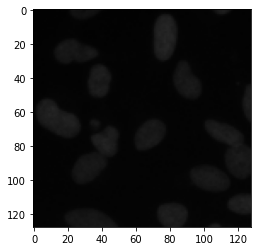

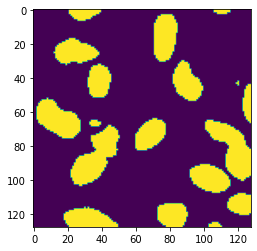

In [39]:
plt.imshow(X_train[0])
plt.show()
plt.imshow(np.squeeze(y_train[0]))
plt.show()

In [54]:
import tensorflow as tf
def create_model():
  inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL))
  s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

  #downsampling
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(s)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
  c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
  p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
  c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)
  p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

  #upsampling
  u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
  c6 = tf.keras.layers.Dropout(0.2)(c6)
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

  u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
  c7 = tf.keras.layers.Dropout(0.2)(c7)
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

  u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)

  u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)

  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

In [55]:
model = create_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_6 (Lambda)              (None, 128, 128, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv2d_37 (Conv2D)             (None, 128, 128, 16  448         ['lambda_6[0][0]']               
                                )                                                                 
                                                                                              

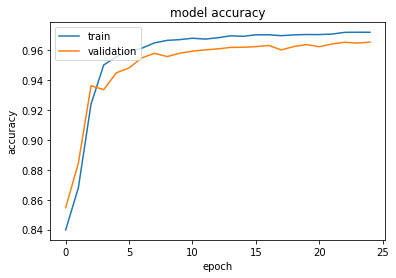

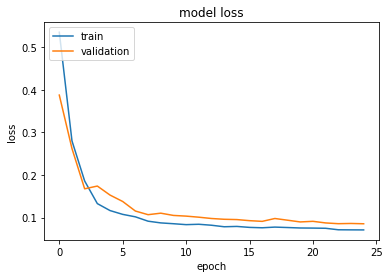

In [60]:
def visualize(result):
  plt.plot(result.history['accuracy'])
  plt.plot(result.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # "Loss"
  plt.plot(result.history['loss'])
  plt.plot(result.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [71]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')]
try:
  model = tf.keras.models.load_model('saved_model/my_model')
except:
  print("File not found")
  result = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)
  visualize(result)
  !mkdir -p saved_model
  model.save('saved_model/my_model')

In [64]:
pred_train = model.predict(X_train[:int(X_train.shape[0]*0.9)])
pred_val = model.predict(X_train[int(X_train.shape[0]*0.9):])

3/3 [==============================] - 3s 703ms/step


In [72]:
pred_train_t = (pred_train>0.5).astype(np.uint8)
pred_val_t = (pred_val>0.5).astype(np.uint8)

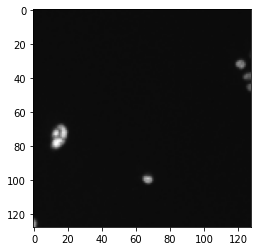

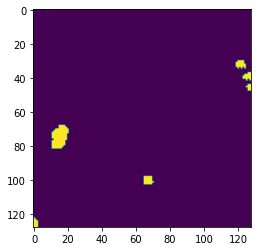

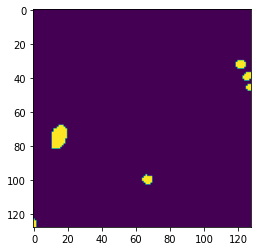

In [67]:
i = np.random.randint(0, len(pred_train_t))
plt.imshow(X_train[i])
plt.show()

plt.imshow(np.squeeze(y_train[i]))
plt.show()

plt.imshow(np.squeeze(pred_train_t[i]))
plt.show()

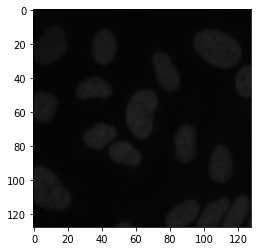

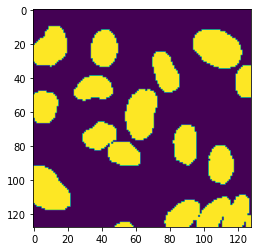

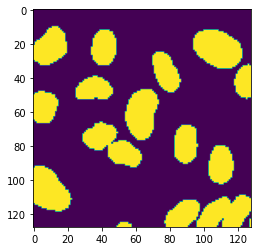

In [70]:
i = np.random.randint(0, len(pred_val_t))
plt.imshow(X_train[int(X_train.shape[0]*0.9):][i])
plt.show()

plt.imshow(np.squeeze(y_train[int(X_train.shape[0]*0.9):][i]))
plt.show()

plt.imshow(np.squeeze(pred_val_t[i]))
plt.show()

In [73]:
print(pred_val_t.shape)

(67, 128, 128, 1)


In [133]:
print(len(test_ids))

3084


In [143]:

X_test = np.zeros((len(test_ids), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL), dtype=np.uint8)
for i,id in enumerate(test_ids):
  fname = TEST_PATH+id+'/images/'+id+'.png'
  X_test[i] = cv2.resize(cv2.imread(fname), (128, 128))

In [144]:
pred_test = model.predict(X_test)

97/97 [==============================] - 136s 1s/step


In [145]:
pred_test_t = (pred_test>0.5).astype(np.uint8)

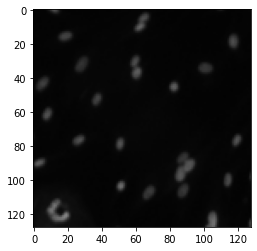

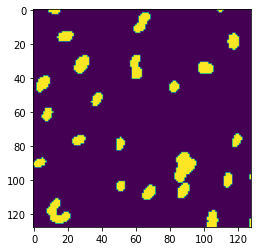

In [146]:
i = np.random.randint(0, len(X_test))
plt.imshow(X_test[i])
plt.show()

plt.imshow(np.squeeze(pred_test_t[i]))
plt.show()

In [147]:
ans = [""]*len(test_ids)
for i,id in enumerate(test_ids):
  fname = TEST_PATH+id+'/images/'+id+'.png'
  H, W, _ = cv2.imread(fname).shape
  img = cv2.resize(pred_test_t[i], (W, H))
  pixel = 0
  for h in range(H):
    l = 0
    for w in range(W):
      if(img[h, w]==1):
        l = l+1
      else:
        if(l!=0):
          ans[i] = ans[i] + " " + str(pixel-l) + " " + str(l)
        l = 0
      pixel = pixel+1
    if(l!=0):
          ans[i] = ans[i] + " " + str(pixel-l) + " " + str(l)


In [148]:
import pandas as pd
df = pd.DataFrame()
df = df.assign(ImageId=test_ids,EncodedPixels=ans)

In [149]:
df.to_csv('submission.csv', index=False)

In [150]:
!kaggle competitions submit -c data-science-bowl-2018 -f submission.csv -m "1st submit"

100% 29.7M/29.7M [00:01<00:00, 16.7MB/s]
Successfully submitted to 2018 Data Science Bowl 